In [1]:
#! /usr/bin/env python3
import importlib
import inspect
import pprint
import os
from pathlib import Path
#
from Pegasus.api import *
pegasus_graphviz = importlib.import_module("pegasus-graphviz")

import graphviz as graphviz
import pygraphviz as pgv
from IPython.display import Image
from IPython.display import IFrame
from wand.image import Image as WImage


import yaml as yaml
import pydot as pydot

import itertools
import copy
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib import rcParams

%matplotlib inline

import ast
from PIL import ImageColor
import ipyplot

from pprint import pprint
from IPython.core.debugger import set_trace

import logging

logging.basicConfig(level=logging.INFO)

BINARY_PATH='/home/scitech/shared-data/maestro-binaries/'
SCRATCH_PATH='/home/scitech/shared-data/scratch/'

In [2]:
def build_transformation_catalog(tc_target, wf):
    
    tc = TransformationCatalog()
    trans = {}

    exes = {}
    binary_path = BINARY_PATH
    base_dir = os.path.dirname(binary_path)
    print('base_dir is', base_dir)   

    container = None
    if tc_target == 'container':
        container = Container('montage',
            Container.SINGULARITY,
            'library://rynge/default/montage:latest'
            ).add_env(MONTAGE_HOME='/opt/Montage')
        tc.add_containers(container)

    for fname in os.listdir(base_dir):
        #print('Making Transformation for', fname)
        transformation = None
        if fname[0] == '.':
            continue

        if tc_target == 'regular':
            transformation = Transformation(fname, 
                                            site='local',
                                            pfn=os.path.join(base_dir, fname), 
                                            is_stageable=True)
            transformation.add_env(PATH='/usr/bin:/bin:.')
        else:
            # container
            transformation = Transformation(fname,
                                            site='insidecontainer',
                                            pfn=os.path.join(base_dir, fname),
                                            container=container,
                                            is_stageable=True)

        # memory requirement
        transformation.add_profiles(Namespace.CONDOR, 'request_memory', '1 GB')

        # some transformations can be clustered for effiency
        #if fname in ['gmProject', 'mDiff', 'mDiffFit', 'mBackground']:
        #    transformation.add_profiles(Namespace.PEGASUS, 'clusters.size', '3')

        # keep a handle to added ones, for use later
        trans[fname] = transformation
            
        tc.add_transformations(transformation)

    # some Montage tools depend on other tools
    #trans['mDiffFit'].add_requirement(trans['mDiff'])
    #trans['mDiffFit'].add_requirement(trans['mFitplane'])

    wf.add_transformation_catalog(tc)


In [3]:
def build_site_catalog():
    # create a SiteCatalog object
    sc = SiteCatalog()

    # -----------------------------------------------
    # create a "local" site
    local = Site("local", arch=Arch.X86_64, os_type=OS.LINUX)

    #pprint(dir(Directory))
    # create and add a shared scratch and local storage directories to the site "local"
    local_shared_scratch_dir = Directory(Directory.SHARED_SCRATCH, path=SCRATCH_PATH)\
        .add_file_servers(FileServer("file://" + SCRATCH_PATH, Operation.ALL))

    #local_local_storage_dir = Directory(Directory.LOCAL_STORAGE, path="/tmp/pegasus/local")\
    #                            .add_file_servers(FileServer("file:///tmp/pegasus/local", Operation.ALL))
    local_shared_binary_dir = Directory(Directory.LOCAL_STORAGE, path=BINARY_PATH)\
        .add_file_servers(FileServer("file://" + BINARY_PATH, Operation.ALL))

    local.add_directories(local_shared_scratch_dir, local_shared_binary_dir)

    
    # -----------------------------------------------
    # create a "condorpool" site
    condorpool = Site("condorpool")\
                    .add_pegasus_profile(style="condor")\
                    .add_pegasus_profile(auxillary_local="true")\
                    .add_condor_profile(universe="local")

    # create and add a shared scratch directory to the site "condorpool"
    condorpool_shared_scratch_dir = Directory(Directory.SHARED_SCRATCH, path=SCRATCH_PATH)\
        .add_file_servers(FileServer("file://" + SCRATCH_PATH, Operation.ALL))
#     condorpool_local_storage_dir = Directory(Directory.LOCAL_STORAGE, path=SCRATCH_PATH)\
#         .add_file_servers(FileServer("file://" + SCRATCH_PATH, Operation.ALL))
    condorpool_shared_binary_dir = Directory(Directory.LOCAL_STORAGE, path=BINARY_PATH)\
        .add_file_servers(FileServer("file://" + BINARY_PATH, Operation.ALL))
    
    condorpool.add_directories(condorpool_shared_scratch_dir, condorpool_shared_binary_dir)

    # -----------------------------------------------                
    # add the sites to the site catalog object
    sc.add_sites(local, condorpool)

    # write the site catalog to the default path "./sites.yml"
    #set_trace()
    sc.write()
    
    return sc

In [4]:
def build_properties():
    props = Properties() 
    #props["pegasus.mode"] = "development"
    #props["pegasus.data.configuration"] = "sharedfs"
    #props["pegasus.code.generator"] = "Shell"
    props.write()
    return props

In [5]:
def cdo_name(file):
    return file # 'CDO-' + file

In [78]:
# -----------------------------------------------------------
# Define a subclass of the pegasus workflow object 
#
# Override pegasus job insertion, to customize for CDOs
#
class Maestro_Workflow(Workflow):
    
    def __init__(self, cdo_dependency, name: str, infer_dependencies: bool = True):
        print("This is the init function")
        super().__init__(name, infer_dependencies)
        self.cdo_dependency = cdo_dependency
        self.pool_manager = Job("start-pool-manager.sh", node_label="pool-manager")\
                            .add_args(SCRATCH_PATH, "pool-manager", "-T", "3")\
                            .add_metadata(time=1)\
                            .add_metadata(maestro_workflow_core_backend="minio")
        super().add_jobs(self.pool_manager)
        # .add_outputs(File("pool_io"))\

    # find the input to a job that generates the named output
    def find_parent_dependency(self, output):
        for id, job in self.jobs.items():
            # if this output matches the request, find the first input
            for op in job.get_outputs():
                #print('testing', op.lfn, 'against',output)
                if op.lfn == output and len(job.get_inputs())>0:
                    # just get the filename of the first input
                    temp = next(iter(job.get_inputs())).lfn
                    #print('Found a match using', temp)                    
                    return next(iter(job.get_inputs())).lfn
#        return '(' + output + ')`'
        print('No parent for', output)
        return output

    def insert_cdo_jobs(self):

        # Show input output file objects to see which are shared objects
        # for debugging only
        if False:
            for id, job in self.jobs.items():
                for u in job.uses:
                    #print(object.__repr__(u.file), u.file.lfn)
                    ...
                for ip in job.get_inputs():
                    #print('Input', ip, ip.lfn)
                    ...
                for op in job.get_outputs():
                    #print('Output', op, op.lfn)
                    ...
        
        # note that we must rename input and outputs using new file objects
        # to work around shared files that are both input and outputs
        # and are replaced by CDO objects
        i_replacements = {}
        o_replacements = {}
        # store watchers created to prevent creating 2 watchers for the same CDO
        # if it is consumed by more than one process
        watchers = {}
        extra_jobs = []
        for id, job in self.jobs.items():
            #print (id, 'corresponds to', job.node_label)

            # For each input : in -> P -> out
            #   replace with CDO(in) -> watcher -> (in)' -> P -> out
            if len(job.get_inputs())>0:
                for ip in job.get_inputs():
                    cdo_enabled = True
                    if "cdo_disabled" in ip.metadata:
                        cdo_enabled = not ip.metadata['cdo_disabled'].lower() in ['true', '1', 't', 'y', 'yes']                    
                        #print(ip, "is cdo enabled", cdo_enabled)
                    if not cdo_enabled:
                        continue
                    
                    ip_cdo_name = cdo_name(ip.lfn)
                    op_cdo_name = 'trigger-' + ip.lfn
                    node_label = 'watch ' + cdo_name(ip.lfn)
                    cache_label = 'cache ' + cdo_name(ip.lfn)
                    if not node_label in watchers:
                        watcher = Job("cdo-watcher.sh", node_label = node_label)
                        watchers[node_label] = watcher
                        pseudo_parent = self.find_parent_dependency(ip.lfn)
                        watcher.add_inputs(pseudo_parent)
                        watcher.add_outputs(op_cdo_name, stage_out=True)
                        watcher.add_args(ip_cdo_name, op_cdo_name, ".")
                        cache = Job("cdo-cache.sh", node_label = cache_label)
                        cache.add_inputs(pseudo_parent) 
                        cache.add_args(ip_cdo_name, op_cdo_name)
#                         extra_jobs.append(cache)
                    else:
                        watcher = watchers[node_label]
                    # any process that outputs this data will need to rename it to the new input name
                    o_replacements[ip.lfn] = ip_cdo_name
                    # any process that inputs this data will need to rename it to the new output name
                    i_replacements[ip.lfn] = op_cdo_name
                    extra_jobs.append(watcher)
                
            if "final_job" in job.metadata:
                print ('final job', id, 'corresponds to', job.node_label)
                newjob = Job("stop-pool-manager.sh", node_label="stop-pool-manager")
                for op in job.get_outputs():
                    newjob.add_inputs(op.lfn)
                extra_jobs.append(newjob)

        for job in extra_jobs:
            if job._id is None:
                job._id = self._get_next_job_id()
            self.jobs[job._id] = job
        
        for id, job in self.jobs.items():
            for u in job.uses:
                if u.file.lfn in i_replacements:
                    if u._type == "input":
                        #print(u._type, 'replacing', u.file.lfn, 'with', i_replacements[u.file.lfn])
                        u.file = File(i_replacements[u.file.lfn])
                    if u._type == "output":
                        #print(u._type, 'replacing', u.file.lfn, 'with', o_replacements[u.file.lfn])
                        u.file = File(o_replacements[u.file.lfn]) 
                                
        for d, val in self.dependencies.items():
            print('Dependency', d, val)

            
    def execute_using_slurm(self):
        return

        

In [79]:
import re
def regex_increment_first(instring):
    # preceeded by "-" : followed by "-"
    out = re.sub('(?<=-)(\d+)(?=-)', lambda x: str(int(x.group(0)) + 1).zfill(2), instring)
    return out

def regex_increment_last(instring):
    # preceeded by "-" : followed by EOL
    out = re.sub('(?<=-)(\d+$)', lambda x: str(int(x.group(0)) + 1).zfill(2), instring)
    return out

x = "f-04-05"
print(regex_increment_first(x))
print(regex_increment_last(x))

f-05-05
f-04-06


In [80]:
def generate_demo_workflow(wf, rc, maestro=False, iterations=2, forks=2):
    # --- Raw input file -----------------------------------------------------------------
    
    binary_path = BINARY_PATH
    data_path = SCRATCH_PATH
    
    # ---------------------------------------------------------
    fa = File("root-data.txt").add_metadata(creator="biddisco", cdo_disabled="true", maestro_enabled="false", node_label='root')
    rc.add_replica(
       site="local", lfn=fa, pfn=Path(data_path).resolve() / "root-data.txt"
    )
    
    # ---------------------------------------------------------
    files = []
    for f in range(0,forks):
        files.append(File("f-" + str(f) + "-00"))
    
    job_preprocess = Job("process-fork.sh", node_label="preprocess")\
                            .add_args(fa.lfn, *files, 1)              \
                            .add_inputs(fa)                           \
                            .add_outputs(*files, stage_out=True)      \
                            .add_metadata(time=1)                     \
                            .add_metadata(cdo_enabled=True)
    
    job_iter = []
    for i in range(0,iterations):
        out_files = []
        for f in range(0,forks):            
            in_name = files[f].lfn
            #print('input name', in_name)
            out_name = regex_increment_last(in_name)
            #print('output iteration/fork', in_name)
            f_out = File(out_name)            
            f_out.add_metadata(cdo_cache='true')
            out_files.append(f_out)
            
            job_iter.append(Job("process-file.sh", node_label=str(f)+"-process." + str(i))\
                                .add_args(in_name, out_name, 1)\
                                .add_inputs(files[f])\
                                .add_outputs(f_out, stage_out=True)\
                                .add_metadata(time=2)\
                                .add_metadata(cdo_disabled='true'))
        files = out_files

    fd = File("f.o").add_metadata(final_output="true")
    job_analyze = Job("process-join.sh", node_label="analyze")\
                   .add_args(*files, fd, 1)\
                   .add_inputs(*files)\
                   .add_outputs(fd, stage_out=True)\
                   .add_metadata(final_job='true')

    wf.add_jobs(job_preprocess, job_analyze)
    for j in job_iter:
        wf.add_jobs(j)

    if maestro:
        wf.insert_cdo_jobs()
        
    wf.add_replica_catalog(rc)
    wf.write(file=wf.name)
    return wf.path.name

In [81]:
importlib.reload(pegasus_graphviz)

# rrdl = remove redundant dependency links
def display_workflow(workflow_file, rrdl, display_files, leftright):
    #print(dir(workflow_file))
    dot_file = Path(workflow_file).with_suffix('.dot')
    # invoke emit_dot on the workflow : show file input/outputs
    dag = pegasus_graphviz.parse_yamlfile(workflow_file, include_files=display_files)
    
    #pegasus_graphviz.remove_xforms(dag, 'L_0')
    
    if rrdl:
        # remove redundant dependency links
        dag = pegasus_graphviz.transitivereduction(dag)

    # labeloptions = ["label", "xform", "id", "xform-id", "label-xform", "label-id"]
    dot = pegasus_graphviz.emit_dot(dag, label_type='label', outfile=dot_file, leftright=leftright)

    s = graphviz.Source.from_file(dot_file)
    image_file = graphviz.render(filepath=dot_file, engine='dot', format='pdf')
    return image_file # Image(filename=image_file)

This is the init function
base_dir is /home/scitech/shared-data/maestro-binaries
base_dir is /home/scitech/shared-data/maestro-binaries
Rendering f-0-00
Rendering f-0-01
Rendering f-0-02
Rendering f-0-03
Rendering f-0-04
Rendering f-0-05
Rendering f-0-06
Rendering f-0-07
Rendering f-0-08
Rendering f-1-00
Rendering f-1-01
Rendering f-1-02
Rendering f-1-03
Rendering f-1-04
Rendering f-1-05
Rendering f-1-06
Rendering f-1-07
Rendering f-1-08
Rendering f-2-00
Rendering f-2-01
Rendering f-2-02
Rendering f-2-03
Rendering f-2-04
Rendering f-2-05
Rendering f-2-06
Rendering f-2-07
Rendering f-2-08
Rendering f-3-00
Rendering f-3-01
Rendering f-3-02
Rendering f-3-03
Rendering f-3-04
Rendering f-3-05
Rendering f-3-06
Rendering f-3-07
Rendering f-3-08
Rendering f.o
Rendering root-data.txt
final job ID0000003 corresponds to analyze
Rendering f-0-00
Rendering f-0-01
Rendering f-0-02
Rendering f-0-03
Rendering f-0-04
Rendering f-0-05
Rendering f-0-06
Rendering f-0-07
Rendering f-0-08
Rendering f-1-00
R

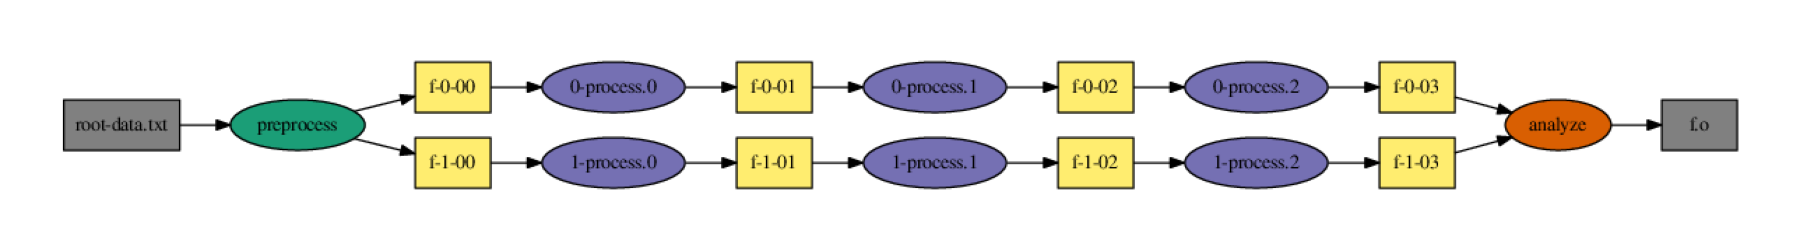

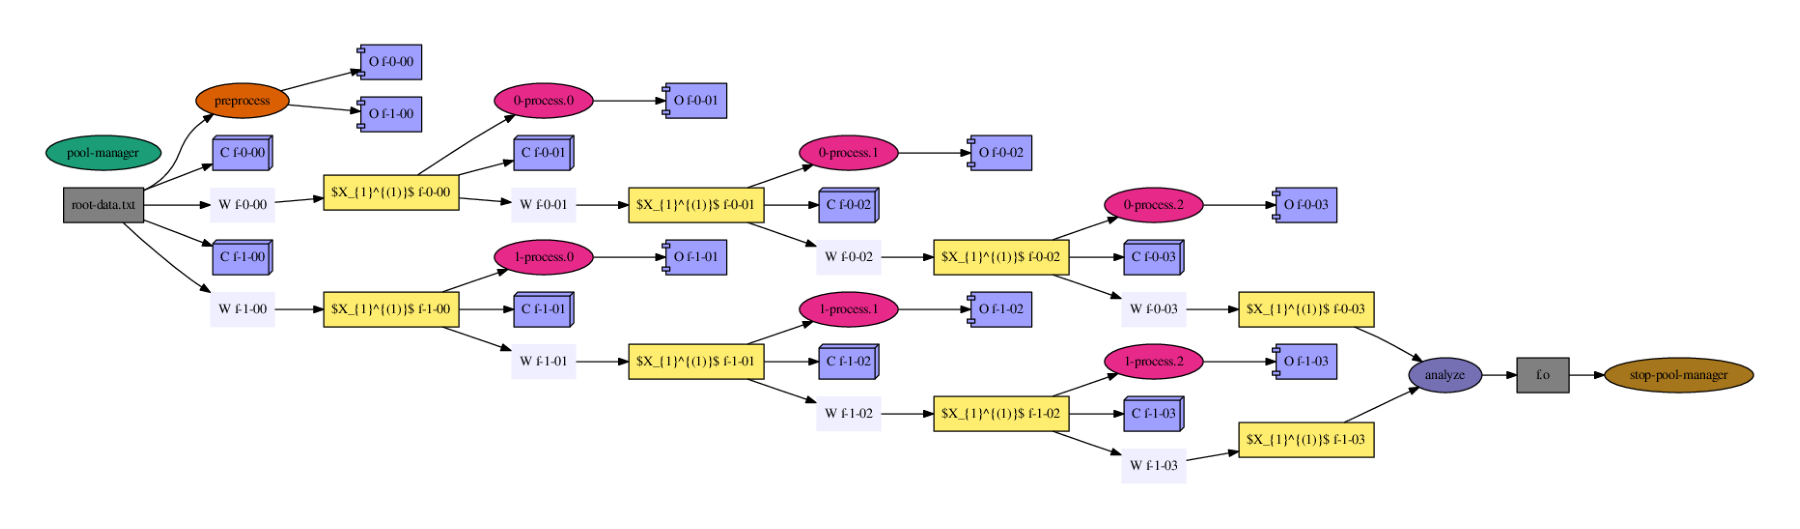

In [82]:
# ---------------------------------------
# cdo_dependencies : false, CDOs are not matched between in/out so CDO consumers do not depend on producers, the DAG is split
#                  : true, CDOs behave like files and trigger dependencies
# display_files : true, files appear as nodes in the graph, otherwise not
# transitive_reduction : true - remove links that are superfluous - transitive, between job-job bypassing files
cdo_dependencies     = False
display_files        = True
transitive_reduction = True
left_right           = True

if os.path.isfile("pegasus.properties"):
    os.remove("pegasus.properties")
if os.path.isfile("sites.yml"):
    os.remove("sites.yml")

rco = ReplicaCatalog()
rcm = ReplicaCatalog()
sco = build_site_catalog()    
prp = build_properties()

# ---------------------------------------
# Generate workflows, one original, one maestro enabled
wfo = Workflow(name="demo-orig.yml")
wfm = Maestro_Workflow(cdo_dependencies, name="demo-maestro.yml")

build_transformation_catalog('regular', wfo)
build_transformation_catalog('regular', wfm)
    
# ---------------------------------------
# Convert workflow into nice DAG display
iterations = 3
forks = 2
file1 = generate_demo_workflow(wfo, rco, iterations=iterations, forks=forks)
I1 = display_workflow(file1, transitive_reduction, display_files, left_right)

file2 = generate_demo_workflow(wfm, rcm, maestro=True, iterations=iterations, forks=forks)
I2 = display_workflow(file2, transitive_reduction, display_files, left_right ) # left_right and cdo_dependencies)


# ---------------------------------------
# rename pdf files based on what options we used to generate the DAG pics
fstring  = "-cdo" if cdo_dependencies else ""
fstring += "-files" if display_files else ""
fstring += "-reduced" if transitive_reduction else ""
image_name1 = I1.replace('.dot.pdf', fstring + '.pdf')
image_name2 = I2.replace('.dot.pdf', fstring + '.pdf')
os.rename(I1, image_name1)
os.rename(I2, image_name2)

# ---------------------------------------
# read+convert PDFs into images
img_A = WImage(filename=image_name1)
img_B = WImage(filename=image_name2)

# ---------------------------------------
# figure size in inches optional
rcParams['figure.figsize'] = 32, 32
# ---------------------------------------
# display images in notebook
fig, ax = plt.subplots(1,1)
ax.imshow(img_A);
ax.set_axis_off()
fig, ax = plt.subplots(1,1)
ax.imshow(img_B);
ax.set_axis_off()

In [ ]:
#wfo.plan(submit=True, sites=['condorpool'], cleanup=False)\
wfm.plan(submit=True, cleanup=False, sites=["condorpool"],verbose=0)\
    .wait()\
    .analyze()\
    .statistics()


################
# pegasus-plan #
################
2021.09.28 09:02:50.397 UTC: [WARNING]  Removing unsupported key request_memory in local universe for job start-pool-manager_sh_ID0000001
2021.09.28 09:02:50.399 UTC: [WARNING]  Removing unsupported key request_memory in local universe for job cdo-watcher_sh_ID0000044
2021.09.28 09:02:50.401 UTC: [WARNING]  Removing unsupported key request_memory in local universe for job cdo-watcher_sh_ID0000043
2021.09.28 09:02:50.402 UTC: [WARNING]  Removing unsupported key request_memory in local universe for job cdo-watcher_sh_ID0000042
2021.09.28 09:02:50.404 UTC: [WARNING]  Removing unsupported key request_memory in local universe for job cdo-watcher_sh_ID0000041
2021.09.28 09:02:50.405 UTC: [WARNING]  Removing unsupported key request_memory in local universe for job process-fork_sh_ID0000002
2021.09.28 09:02:50.407 UTC: [WARNING]  Removing unsupported key request_memory in local universe for job process-file_sh_ID0000007
2021.09.28 09:02:50.40

[########################-]  97.4% ..Failure (Unready: 2, Completed: 111, Queued: 0, Running: 0, Failed: 1))



####################
# pegasus-analyzer #
####################
Your database is compatible with Pegasus version: 5.0.1dev

************************************Summary*************************************

Submit Directory   : /home/scitech/shared-data/maestro-test/scitech/pegasus/demo-maestro.yml/run0001
Total jobs         :    114 (100.00%)
# jobs succeeded   :    111 (97.37%)
# jobs failed      :      1 (0.88%)
# jobs held        :      0 (0.00%)
# jobs unsubmitted :      2 (1.75%)

******************************Failed jobs' details******************************

========================start-pool-manager_sh_ID0000001=========================

last state: POST_SCRIPT_FAILED
site: condorpool
submit file: 00/00/start-pool-manager_sh_ID0000001.sub
output file: 00/00/start-pool-manager_sh_ID0000001.out.000
error file: 00/00/start-pool-manager_sh_ID0000001.err.000

-------------------------------Task #1 - Summary--------------------------------

site        : condorpool
hostname    : 457

PegasusClientError: Pegasus command: ['/home/scitech/pegasus/dist/pegasus/bin/pegasus-analyzer', '/home/scitech/shared-data/maestro-test/scitech/pegasus/demo-maestro.yml/run0001'] FAILED

In [ ]:
wfm.halt()

In [ ]:
left_right = True
I3 = display_workflow('../montage-v3/data/montage-maestro-workflow.yml', True, True, left_right)

# figure size in inches optional
rcParams['figure.figsize'] = 128,128

# read images
img_A = mpimg.imread(I3)
#img_B = mpimg.imread(I2)

# display images
fig, ax = plt.subplots(1,1)
ax.imshow(img_A);
#ax[1].imshow(img_B);

In [ ]:
# display methods of something
# pprint.pprint(dir(wf))

# display args of function
# inspect.getfullargspec(wf.add_jobs)

In [ ]:
with open(workflow_file) as file:
    # The FullLoader parameter handles the conversion from YAML
    # scalar values to Python the dictionary format
    workflow_yaml = yaml.load(file, Loader=yaml.FullLoader)

g_yaml = nx.read_yaml(workflow_file)

g = nx.DiGraph()
nodes = [k['id'] for k in g_yaml['jobs']]
print('Nodes = ', nodes)
g.add_nodes_from(nodes)

# build a list of edges from each node to each child
for v in g_yaml['jobDependencies']:
    clist = [ [v['id'], c] for c in v["children"] ]
    g.add_edges_from(clist)
        
#g.add_edges_from([[v['id'], v['children']] for v in g_yaml['jobDependencies']])
top = nx.bipartite.sets(g)[0]
pos = nx.bipartite_layout(g, top)
#pos = nx.planar_layout(g)
nx.draw_networkx(g, node_shape='o', pos = pos)
    
#for key, value in G['jobDependencies']:
#    print(key, ":", value)
    
#print("\n")

#pprint.pprint(G)


In [ ]:
display_files        = True
transitive_reduction = True
left_right           = True

mv3 = "../montage-v3/data/montage-maestro-workflow.yml" 
I1 = display_workflow(mv3, transitive_reduction, display_files, left_right and cdo_dependencies) 

# ---------------------------------------
# rename pdf files based on what options we used to generate the DAG pics
fstring  = "-cdo" if cdo_dependencies else ""
fstring += "-files" if display_files else ""
fstring += "-reduced" if transitive_reduction else ""
image_name1 = I1.replace('.dot.pdf', fstring + '.pdf')
os.rename(I1, image_name1)

# ---------------------------------------
# read+convert PDFs into images
img_A = WImage(filename=image_name1)

# ---------------------------------------
# figure size in inches optional
rcParams['figure.figsize'] = 64, 64
# ---------------------------------------
# display images in notebook
fig, ax = plt.subplots(1,1)
ax.imshow(img_A);
ax.set_axis_off()
